In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Dropout

### READING THE DATASET

In [ ]:
lines=pd.read_csv("/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/END/Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

### PREPROCESSING

In [ ]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64



1.   USING TED SOURCE



In [ ]:
lines=lines[lines['source']=='ted']

In [ ]:
lines.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है


2. DROPPING NULL VALUES

In [ ]:
pd.isnull(lines).sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [ ]:
lines=lines[~pd.isnull(lines['english_sentence'])]

In [ ]:
lines.shape

(39881, 3)

3. DROPPING DUPLICATES

In [ ]:
lines.drop_duplicates(inplace=True)

In [ ]:
lines.shape

(38803, 3)

4. CHANGING ALL TO LOWERCASE CHARACTERS

In [ ]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

5. REMOVING QUOTES

In [ ]:
# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("“", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("“", '', x))

# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("”", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("”", '', x))

6. REMOVING SPECIAL CHARACTERS

In [ ]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

7. REMOVING DIGITS
8. REMOVING EXTRA SPACES

In [ ]:
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

9. ADDING < START > AND < END > TOKENS

In [ ]:
# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')
lines.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए...
1,ted,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बता...
3,ted,what we really mean is that theyre bad at not ...,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं ...
7,ted,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि व...
13,ted,so there is some sort of justice,START_ तो वहाँ न्याय है _END


10. CREATING ENGLISH AND HINDI VOCABULARY

In [ ]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)
            
len(all_eng_words)

16293

In [ ]:
len(all_hindi_words)

21587

In [ ]:
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
0,ted,politicians do not have permission to do what ...,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए...,12,15
1,ted,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बता...,9,13
3,ted,what we really mean is that theyre bad at not ...,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं ...,12,13
7,ted,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि व...,11,15
13,ted,so there is some sort of justice,START_ तो वहाँ न्याय है _END,7,6


11. SETTING EQUAL MAXIMUM LENGTH OF ENGLSIH AND HINDI SENTENCES   
```DRAWBACK OF LSTM```

In [ ]:
lines[lines['length_eng_sentence']>30].shape

(0, 5)

In [ ]:
lines[lines['length_eng_sentence']>=20].shape

(13, 5)

In [ ]:
lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]
lines.shape

(38477, 5)

In [ ]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [ ]:
max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])
print(max_length_src)

20


In [ ]:
# Differentiating input and target
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(16293, 21587)

In [ ]:
num_encoder_tokens += 1 
num_decoder_tokens += 1 #for zero padding

12. TOKENIZATION

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
lines = shuffle(lines)
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
21216,ted,and thats because the indus script is undeciph...,START_ क्योंकि सिंधु लिपि पढ़ी नहीं जा सकी है।...,8,10
84895,ted,a sense that would give us seamless access,START_ एक इन्द्री जो हमें सहज पहुँचाए _END,8,8
93458,ted,all his predecessors have been all those three,START_ इनसे पहले के बाकी सभी ये तीनो थे _END,8,10
35129,ted,this one they took only minutes,START_ इसके लिए उन्हें सिर्फ मिनट लगे _END,6,8
87970,ted,this is not the way society will work,START_ समाज का ये ढँग बिलकुल सरासर गलत है । _END,8,11


### MODEL PREPARATION

1. TRAIN AND TEST SPLIT

In [ ]:
X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((30781,), (7696,))

2. SAVING PROCESSED DATA

In [ ]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

3. GENERATING BATCHES

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

4. ENCODER-DECODER ARCHITECTURE

In [ ]:
latent_dim=500

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,))

#enc_emb =  Embedding(num_encoder_tokens, vec_len, mask_zero = True)(encoder_inputs)
#enc_emb =  Embedding(num_encoder_tokens, vec_len)(encoder_inputs)
enc_emb = Embedding(input_dim = num_encoder_tokens, output_dim = latent_dim, mask_zero = True)(encoder_inputs)

encoder_dropout = (TimeDistributed(Dropout(rate = 0.2)))(enc_emb)
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True), merge_mode='sum')(encoder_dropout)
encoder_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True), merge_mode='sum')(encoder_lstm1)
encoder_lstm3 = Bidirectional(LSTM(latent_dim, return_sequences=True), merge_mode='sum')(encoder_lstm2)
encoder_LSTM4_layer = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM4_layer(encoder_lstm3)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_dropout = (TimeDistributed(Dropout(rate = 0.2)))(dec_emb)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.


decoder_LSTM_layer = LSTM(latent_dim, return_sequences=True)
decoder_LSTM = decoder_LSTM_layer(decoder_dropout, initial_state = encoder_states)

decoder_LSTM_2_layer = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,_,_ = decoder_LSTM_2_layer(decoder_LSTM)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

5. MODEL SUMMARY

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    4888200     input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 300)    0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 300)    1442400     time_distributed[0][0]           
______________________________________________________________________________________________

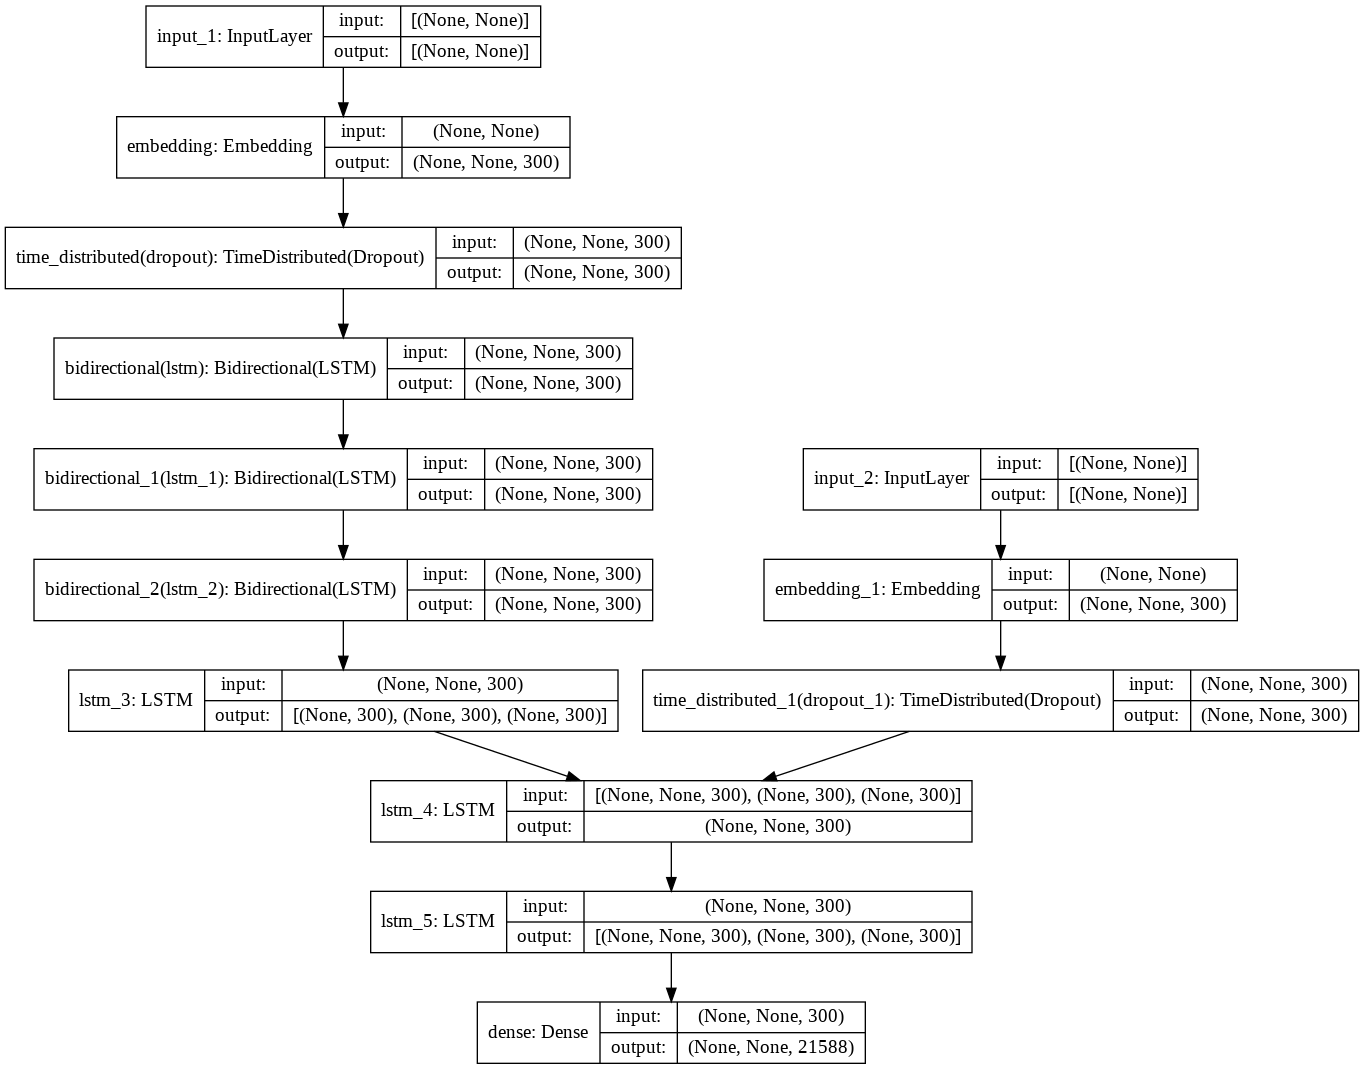

In [ ]:
import tensorflow as tf
dot_img_file = '/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/3/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

6. TRAINING

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
240/240 [==============================] - 91s 224ms/step - loss: 3.1483 - val_loss: 2.7608
Epoch 2/100
240/240 [==============================] - 43s 180ms/step - loss: 2.6671 - val_loss: 2.6495
Epoch 3/100
240/240 [==============================] - 42s 174ms/step - loss: 2.5299 - val_loss: 2.5753
Epoch 4/100
240/240 [==============================] - 42s 174ms/step - loss: 2.4291 - val_loss: 2.5356
Epoch 5/100
240/240 [==============================] - 42s 175ms/step - loss: 2.3502 - val_loss: 2.5076
Epoch 6/100
240/240 [==============================] - 41s 172ms/step - loss: 2.2785 - val_loss: 2.4844
Epoch 7/100
240/240 [==============================] - 41s 171ms/step - loss: 2.2148 - val_loss: 2.4577
Epoch 8/100
240/240 [==============================] - 41s 171ms/step - loss: 2.1544 - val_loss: 2.4488
Epoch 9/100
240/240 [==============================] - 42s 174ms/step - loss: 2.0980 - val_loss: 2.4441
Epoch 10/100
240/240 [==============================] - 42s 173m

7. SAVE THE MODEL
8. LOAD THE MODEL

In [ ]:
model.save_weights('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/3/nmt_weights-1.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/3/nmt_weights-1.h5')

### PREDICTIONS
```ALONG WITH THE INDIVIDUAL BLEU SCORES```

1. ENCODER-DECODER FOR OUTPUT

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence
decoder_dropout2 = (TimeDistributed(Dropout(rate = 0.2)))(dec_emb2)
decoder_LSTM2 = decoder_LSTM_layer(decoder_dropout2, initial_state = decoder_states_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_LSTM_2_layer(decoder_LSTM2)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) #A dense softmax layer to generate prob dist. over the target vocabulary


# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 98):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

2. RESULTS

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
#Output and the coresposponding BLEU score
import random
import nltk
import warnings
warnings.filterwarnings('ignore')

In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu1 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu1)

Input English sentence: laughter
Actual Hindi Translation:  हँसते हुए 
Predicted Hindi Translation:  जबकि 
0.6051012508914458


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu2 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu2)

Input English sentence: is the window through which you reach out to people
Actual Hindi Translation:  लोगों तक पहुंचने का माध्यम है 
Predicted Hindi Translation:  हम एक चाहते पकड़ 
0.42163717760099034


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu3 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu3)

Input English sentence: this was something really really revolutionary
Actual Hindi Translation:  यह सच में बहुत क्रांतिकारी था 
Predicted Hindi Translation:  लेकिन वाली चलता संबंधी 
0.4578577223563162


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu4 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu4)

Input English sentence: the answer is
Actual Hindi Translation:  जवाब है 
Predicted Hindi Translation:  किसी वयस्क मूलतः 
0.6529942057256104


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu5 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu5)

Input English sentence: that means the whole universe
Actual Hindi Translation:  यानि पूरे ब्रह्मांड को 
Predicted Hindi Translation:  जो बहुत से ज्यादा जाकर नहीं 
0.5037455800910576


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu6 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu6)

Input English sentence: to protest something
Actual Hindi Translation:  किसी बात के विरोध में 
Predicted Hindi Translation:  और सकता भरा हुआ उठाने की 
0.4687405329188213


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu7 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu7)

Input English sentence: my kid went to college because of your book
Actual Hindi Translation:  मेरा बच्चा आपकी पुस्तक की वजह से 
Predicted Hindi Translation:  और परिप्रेक्ष्य कुछ करनी है जो इलाज लोग 
0.42728700639623407


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu8 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu8)

Input English sentence: i came up with a saying
Actual Hindi Translation:  तो मैने एक लाइन कही 
Predicted Hindi Translation:  सिर्फ अजीब 
0.5173303724502314


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu9 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu9)

Input English sentence: but i offered the suggestion
Actual Hindi Translation:  पर मैंने यह सुझाव भी दिया 
Predicted Hindi Translation:  तो एक चाहूँगा मिलती 
0.4470407507936367


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu10 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu10)

Input English sentence: next thing you knew theres a full page covering us positively
Actual Hindi Translation:  और पलक झपकते ही हमें पूरे पेज की बढिया कवरेज मिली थी 
Predicted Hindi Translation:  ये बहुत से ज्यादा से अधिक से ज्यादा से बड़ी ख़ुद एक प्रतिदिन 
0.49424885090507165


### AVERAGE BLEU SCORE

In [ ]:
#BLEU Score
bleu = (bleu1+bleu2+bleu3+bleu4+bleu5+bleu6+bleu7+bleu8+bleu9+bleu10)/10
print('Average BLEU Score of the Model:', bleu)

Average BLEU Score of the Model: 0.49959834501294154
